# Imports

In [14]:
# for importing code
import sys, os

module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)

In [17]:
import pandas as pd
from constants import PROJECT_ROOT

# created by: uv run python src/classify_twitter_posts.py --model anthropic/claude-sonnet-4 --temperature 0.1 --n-samples 750 --min-chars 50 --results_filename twitter_posts_classified
path = (
    f"{PROJECT_ROOT}/outputs/500_samples_ihra_half_antisemitic_no_urls/twitter_posts_classified_IHRA_2025-09-11-H:11-M:24.csv"
)

df = pd.read_csv(path)
df = df.rename(columns={"biased": "is_antisemitic"})
df

,original_index,text,is_antisemitic,keyword,prediction,description,model,max_tokens,temperature,usage
0,113,"Following query, The Prime Minister’s Office ...",0,Israel,False,This text is a factual report about Israel's o...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3812, 'completion_tokens': 7..."
1,848,"To the Jews, crucifixion is a stumbling block....",0,Jews,False,This text appears to be a religious commentary...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3821, 'completion_tokens': 9..."
2,346,Lots of American Jews feeling no Love for Righ...,0,Jews,False,The text criticizes the Israeli government as ...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3793, 'completion_tokens': 1..."
3,121,"On a 1 to 10 scale, how important is the Israe...",0,Israel,False,This text is a neutral question asking for an ...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3799, 'completion_tokens': 7..."
4,734,"Hang on, is it NOT common knowledge amongst pp...",0,Jews,False,This text discusses theological similarities b...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3796, 'completion_tokens': 6..."
...,...,...,...,...,...,...,...,...,...,...
495,636,A lot of y’all ladies be talkin cash shit but...,1,Jews,True,The text uses 'jews' as a derogatory term or i...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3784, 'completion_tokens': 9..."
496,1375,the WHAT now??? do you not know that there are...,1,Jews,False,The text expresses support for Palestinian fre...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3812, 'completion_tokens': 8..."
497,606,"He said Adelson, not Jews. Adelson has given $...",1,Jews,False,The text refers specifically to Adelson as an ...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3809, 'completion_tokens': 6..."
498,408,respected his God and father John 20:17? Far t...,1,Jews,True,The text makes stereotypical allegations about...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3826, 'completion_tokens': 1..."


# Data Config:
- model: anthropic/claude-sonnet-4 
- temperature 0.1 
- n-samples 750
- min-chars 50 
- Antisemitism samples: 525
- Non-Antisemitism samples: 225

# Cost

In [18]:
import json
import pandas as pd
import ast


# Try different parsing methods
def safe_parse_usage(usage_str):
    try:
        # Try JSON first
        return json.loads(usage_str)
    except Exception:
        try:
            # Try ast.literal_eval for Python dict strings
            return ast.literal_eval(usage_str)
        except Exception:
            try:
                # Try eval as last resort (if it's a Python dict)
                return eval(usage_str)
            except Exception:
                return None


def print_costs(df_origin):
    df = df_origin.copy()
    # Parse the usage column
    df["usage_parsed"] = df["usage"].apply(safe_parse_usage)

    # Check how many failed to parse
    failed_count = df["usage_parsed"].isnull().sum()
    print(f"Failed to parse: {failed_count} rows out of {len(df)}")

    # Extract token counts (handle None values)
    df["prompt_tokens"] = df["usage_parsed"].apply(
        lambda x: x["prompt_tokens"] if x else 0
    )
    df["completion_tokens"] = df["usage_parsed"].apply(
        lambda x: x["completion_tokens"] if x else 0
    )
    df["total_tokens"] = df["usage_parsed"].apply(
        lambda x: x["total_tokens"] if x else 0
    )

    # Calculate totals
    total_prompt_tokens = df["prompt_tokens"].sum()
    total_completion_tokens = df["completion_tokens"].sum()
    total_tokens = df["total_tokens"].sum()

    # Claude Sonnet 4 pricing: $3/M input, $15/M output
    input_cost = (total_prompt_tokens / 1_000_000) * 3
    output_cost = (total_completion_tokens / 1_000_000) * 15
    total_cost = input_cost + output_cost

    print(f"Total Prompt Tokens: {total_prompt_tokens:,}")
    print(f"Total Completion Tokens: {total_completion_tokens:,}")
    print(f"Total Tokens: {total_tokens:,}")
    print("\nCost Breakdown:")
    print(f"Input Cost: ${input_cost:.4f}")
    print(f"Output Cost: ${output_cost:.4f}")
    print(f"Total Cost: ${total_cost:.4f}")




print_costs(df)
print("\n")

Failed to parse: 2 rows out of 500
Total Prompt Tokens: 1,901,120
Total Completion Tokens: 44,005
Total Tokens: 1,945,125

Cost Breakdown:
Input Cost: $5.7034
Output Cost: $0.6601
Total Cost: $6.3634




# EDA

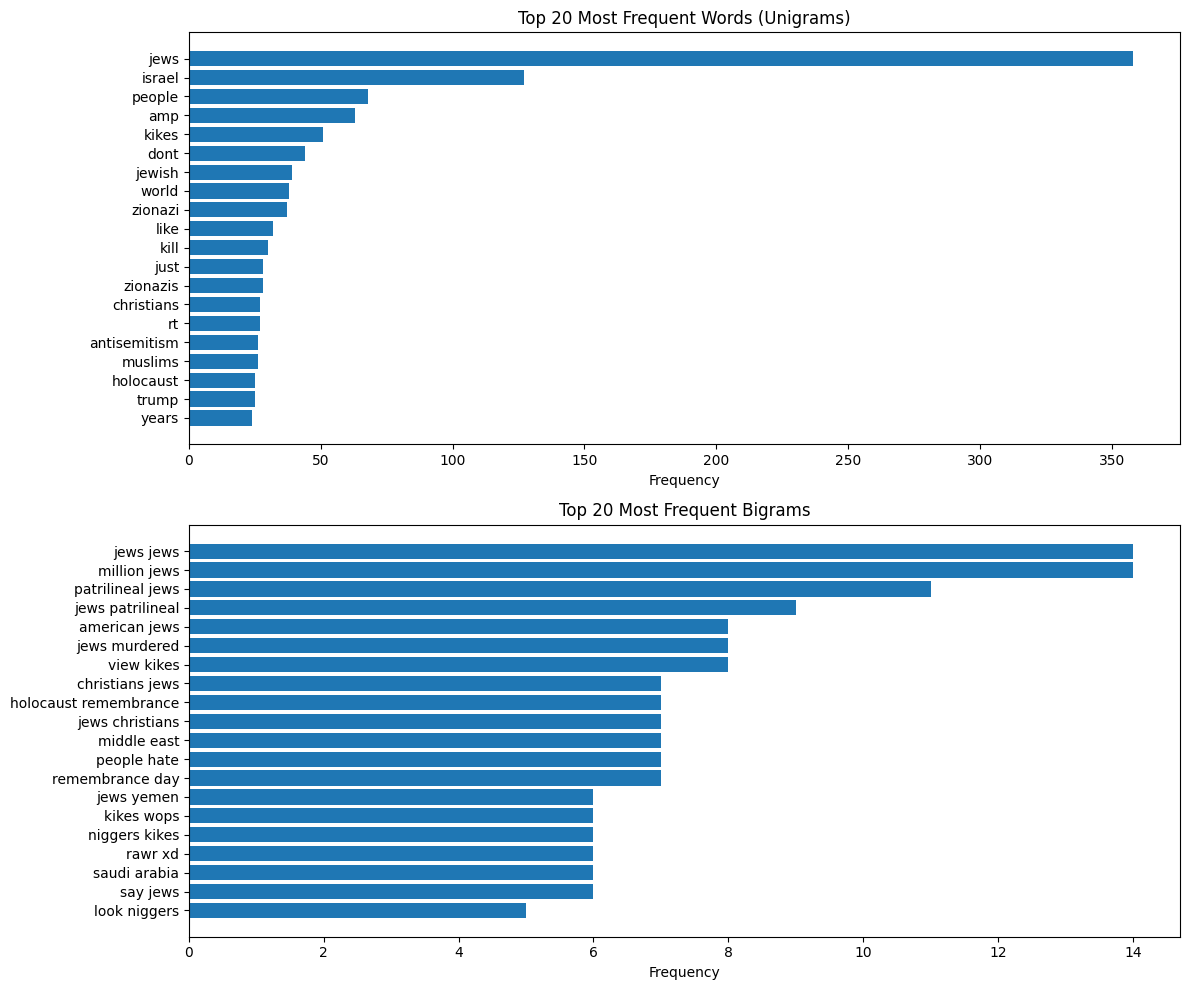

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer


# Clean and prepare text data
def clean_text(text):
    # Convert to lowercase, remove URLs, mentions, and special characters
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    return text.strip()


# Clean all text
df["text_clean"] = df["text"].apply(clean_text)

# Get most frequent words (unigrams)
vectorizer_unigrams = CountVectorizer(
    stop_words="english", max_features=20, ngram_range=(1, 1)
)
unigram_matrix = vectorizer_unigrams.fit_transform(df["text_clean"])
unigram_counts = unigram_matrix.sum(axis=0).A1
unigram_freq = [
    (word, count)
    for word, count in zip(vectorizer_unigrams.get_feature_names_out(), unigram_counts)
]
unigram_freq = sorted(unigram_freq, key=lambda x: x[1], reverse=True)

# Get most frequent bigrams
vectorizer_bigrams = CountVectorizer(
    stop_words="english", max_features=20, ngram_range=(2, 2)
)
bigram_matrix = vectorizer_bigrams.fit_transform(df["text_clean"])
bigram_counts = bigram_matrix.sum(axis=0).A1
bigram_freq = [
    (word, count)
    for word, count in zip(vectorizer_bigrams.get_feature_names_out(), bigram_counts)
]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot unigrams
words, counts = zip(*unigram_freq)
ax1.barh(range(len(words)), counts)
ax1.set_yticks(range(len(words)))
ax1.set_yticklabels(words)
ax1.set_xlabel("Frequency")
ax1.set_title("Top 20 Most Frequent Words (Unigrams)")
ax1.invert_yaxis()

# Plot bigrams
bigrams, bigram_counts = zip(*bigram_freq)
ax2.barh(range(len(bigrams)), bigram_counts)
ax2.set_yticks(range(len(bigrams)))
ax2.set_yticklabels(bigrams)
ax2.set_xlabel("Frequency")
ax2.set_title("Top 20 Most Frequent Bigrams")
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Prediction stats


In [35]:
# original_text = pd.read_csv(
#     f"{PROJECT_ROOT}/datasets/GoldStanderDataSet.csv",
#     encoding="cp1252",
#     low_memory=False,
# )
# original_text = original_text.rename(columns={"Text": "original_text"})
# original_text = original_text.reset_index().rename(columns={"index": "original_index"})

# original_text = original_text[["original_index", "original_text", "Username"]]

In [36]:
# to_manual_review = merged_df[
#     [
#         "original_index",
#         "text",
#         "is_antisemitic",
#         "keyword",
#         "prediction_both_def",
#         "description",
#         "prediction_IHRA",
#         "description_IHRA",
#         "prediction_JD",
#         "description_JD",
#     ]
# ]

# to_manual_review["error_by_ihra"] = (
#     to_manual_review["is_antisemitic"] != to_manual_review["prediction_IHRA"]
# )
# to_manual_review["error_by_jd"] = (
#     to_manual_review["is_antisemitic"] != to_manual_review["prediction_JD"]
# )
# to_manual_review["is_antisemitic"] = to_manual_review["is_antisemitic"].astype(bool)
# to_manual_review = pd.merge(
#     to_manual_review, original_text, on="original_index", how="left"
# )
# to_manual_review.to_csv(
#     f"{PROJECT_ROOT}/outputs/twitter_posts_to_manual_review.csv", index=False
# )

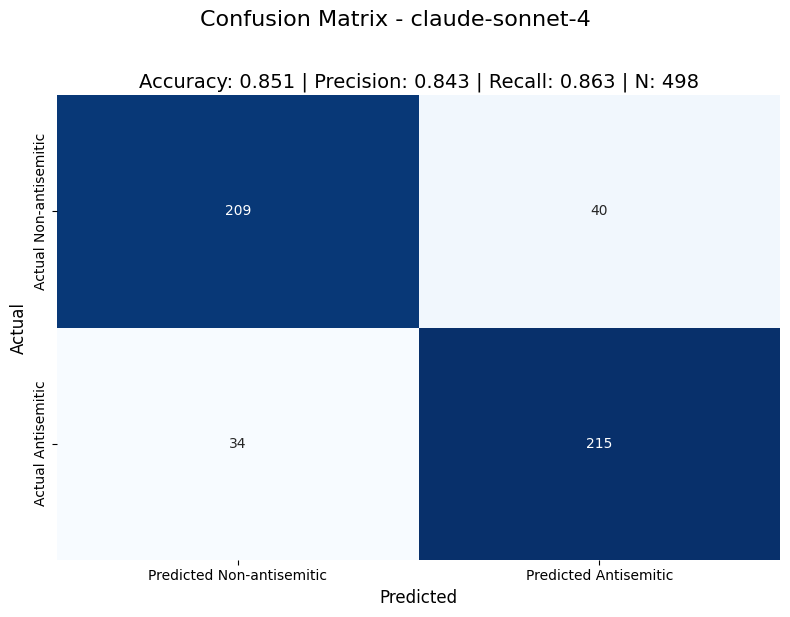

Confusion Matrix Results:
Accuracy: 0.8514
Precision: 0.8431
Recall: 0.8635
Samples: 498


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
)

PRED_COL = "prediction"  # Single prediction column
TRUTH_COL = "is_antisemitic"


def coerce_to_binary(s: pd.Series) -> pd.Series:
    """
    Convert common truthy/falsey values to {0,1}, keep unknowns as NaN.
    Handles bools, 0/1, and strings like 'true','false','yes','no'.
    """
    if s.dtype == bool:
        return s.astype(int)
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce").round().clip(0, 1).astype("Int64")
    # strings
    true_vals = {"true", "1", "yes", "y", "t", "antisemitic"}
    false_vals = {"false", "0", "no", "n", "f", "non-antisemitic", "not antisemitic"}
    ss = s.astype(str).str.strip().str.lower()
    mapped = ss.map(
        lambda x: 1 if x in true_vals else (0 if x in false_vals else np.nan)
    )
    return pd.Series(mapped, index=s.index, dtype="float")


def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    return cm, precision, recall, accuracy


# Prepare truth and prediction
y_true_all = coerce_to_binary(df[TRUTH_COL])
y_pred_all = coerce_to_binary(df[PRED_COL])

# Align and drop rows with NaNs in either
mask = (~pd.isna(y_true_all)) & (~pd.isna(y_pred_all))
y_true = y_true_all[mask].astype(int)
y_pred = y_pred_all[mask].astype(int)

cm, precision, recall, accuracy = calculate_metrics(y_true, y_pred)

# Get model name if available
model_name = None
if "model" in df.columns and df["model"].notna().any():
    try:
        model_name = df["model"].dropna().iloc[0].split("/")[-1]
    except Exception:
        model_name = df["model"].dropna().iloc[0]

# Plot confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Predicted Non-antisemitic", "Predicted Antisemitic"],
    yticklabels=["Actual Non-antisemitic", "Actual Antisemitic"],
    ax=ax,
)

title_bits = [
    f"Accuracy: {accuracy:.3f}",
    f"Precision: {precision:.3f}",
    f"Recall: {recall:.3f}",
    f"N: {int(mask.sum())}",
]
ax.set_title(" | ".join(title_bits), fontsize=14)
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)

if model_name:
    fig.suptitle(f"Confusion Matrix - {model_name}", y=1.02, fontsize=16)

plt.tight_layout()
plt.show()

# Print metrics
print(f"Confusion Matrix Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Samples: {int(mask.sum())}")

In [12]:
#show false negatuves:
false_negatives = df[(y_true == 1) & (y_pred == 0)]
false_positives = df[(y_true == 0) & (y_pred == 1)]
pd.concat([false_negatives, false_positives])

,original_index,text,is_antisemitic,keyword,prediction,description,model,max_tokens,temperature,usage,text_clean
251,3417,RT : Israel is using internationally prohibite...,1,Israel,False,This text criticizes specific Israeli military...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3844, 'completion_tokens': 8...",rt israel is using internationally prohibited ...
253,3274,RT : The Israeli Interior Ministry maintains a...,1,Israel,False,The text criticizes Israeli military targeting...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3833, 'completion_tokens': 8...",rt the israeli interior ministry maintains a l...
255,1876,Such growing noble sentiments by US Jews/Israe...,1,Jews,False,The text expresses positive sentiment toward U...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3810, 'completion_tokens': 8...",such growing noble sentiments by us jewsisrael...
258,3434,Retweet and show the world if you agree with m...,1,Israel,False,The text criticizes Israel's actions and calls...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3948, 'completion_tokens': 8...",retweet and show the world if you agree with m...
261,2134,Modern Judaism might worship a god called Hash...,1,Jews,False,This text presents a theological argument abou...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3854, 'completion_tokens': 8...",modern judaism might worship a god called hash...
...,...,...,...,...,...,...,...,...,...,...,...
194,2681,Prince Charles: 'Foreign Jews' to blame for Mi...,0,Jews,True,The text attributes blame for Middle East turm...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3803, 'completion_tokens': 1...",prince charles foreign jews to blame for middl...
195,1586,This is just like when Hitler Tattooed the Jew...,0,Jews,True,The text draws a comparison between contempora...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3809, 'completion_tokens': 8...",this is just like when hitler tattooed the jew...
207,1378,"If Hitler had killed jews, How there are still...",0,Jews,True,This text denies the Holocaust by questioning ...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3803, 'completion_tokens': 8...",if hitler had killed jews how there are still ...
225,1354,"Ilhan Omar: 'If Israel Is So Innocent, Then Wh...",0,Jews,True,This text presents a fabricated quote that por...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3815, 'completion_tokens': 9...",ilhan omar if israel is so innocent then why d...


In [ ]:
#False positives:

print("\nFalse Positives:")
false_positives


False Positives:


,original_index,text,is_antisemitic,keyword,prediction,description,model,max_tokens,temperature,usage,text_clean
15,1320,Charlamagne Tha God Says Viacom Dropping Nick ...,0,Jews,True,The text promotes the antisemitic stereotype t...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3824, 'completion_tokens': 8...",charlamagne tha god says viacom dropping nick ...
27,2051,Brazilian journalist says Brazil would need to...,0,Jews,True,The text reports on a journalist's statement t...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3836, 'completion_tokens': 1...",brazilian journalist says brazil would need to...
29,2919,RT : The Palestinians send their children to k...,0,Jews,True,The text makes a stereotypical allegation abou...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3801, 'completion_tokens': 1...",rt the palestinians send their children to kil...
33,539,Oligarch Sheldon Adelson Arranges a Hero’s Wel...,0,Israel,True,The text employs the antisemitic stereotype of...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3814, 'completion_tokens': 9...",oligarch sheldon adelson arranges a heros welc...
46,725,There is a horrific irony in Bret's bigoted op...,0,Jews,True,The text makes stereotypical allegations about...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3845, 'completion_tokens': 1...",there is a horrific irony in brets bigoted ope...
76,2613,21 year old Palestinian woman murdered by her ...,0,Jews,True,The text contains the antisemitic allegation t...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3816, 'completion_tokens': 1...",21 year old palestinian woman murdered by her ...
81,1056,"""Jews are not people; they are animals.""\n- Ad...",0,Jews,True,The text contains a dehumanizing allegation ab...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3822, 'completion_tokens': 8...",jews are not people they are animalsn adolph h...
85,1303,America 2020: Auschwitz is trending on Twitter...,0,Jews,True,The text describes a lockdown protester using ...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3838, 'completion_tokens': 9...",america 2020 auschwitz is trending on twitter ...
88,2798,"WARNING: They tell us who they are, when will ...",0,Jews,True,The text promotes hatred toward Jews and Chris...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3860, 'completion_tokens': 9...",warning they tell us who they are when will je...
105,215,The ukthi in the video is basically Indonesia ...,0,Israel,True,The text reports on antisemitic content where ...,anthropic/claude-sonnet-4,800,0.0,"{'prompt_tokens': 3866, 'completion_tokens': 1...",the ukthi in the video is basically indonesia ...
